<a href="https://colab.research.google.com/github/kim-bo-saeng/dacon_jeju/blob/master/jeju_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### 라이브러리 가져오기

In [11]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

In [12]:
# 한글폰트사용하기

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


### 데이터 전처리

In [13]:
row_data = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/201901-202003.csv')
print(row_data.shape)
row_data.tail()

(24697792, 12)


,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6
24697791,202003,충북,충주시,휴양콘도 운영업,충북,충주시,60s,1,5,3,194000,3


In [24]:
# 2019년 1월/2월/3월/4월 + 2020년 1월/2월/3월 만 뽑은 데이터
data1901234_20123 = row_data[(row_data['REG_YYMM'] == 201901) | (row_data['REG_YYMM'] == 201902) | (row_data['REG_YYMM'] == 201903) | (row_data['REG_YYMM'] == 201904) |
                             (row_data['REG_YYMM'] == 202001) | (row_data['REG_YYMM'] == 202002) | (row_data['REG_YYMM'] == 202003)
                            ]
data1901234_20123

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3
...,...,...,...,...,...,...,...,...,...,...,...,...
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6


In [57]:
# 2019년 1월/2월/3월/4월 + 2020년 1월/2월/3월 에서  REG_YYMM / CARD_SIDO_NM / STD_CLSS_NM / AMT 만뽑은 데이터
data1901234_20123 = row_data[(row_data['REG_YYMM'] == 201901) | (row_data['REG_YYMM'] == 201902) | (row_data['REG_YYMM'] == 201903) | (row_data['REG_YYMM'] == 201904) |
                             (row_data['REG_YYMM'] == 202001) | (row_data['REG_YYMM'] == 202002) | (row_data['REG_YYMM'] == 202003)
                            ]
data1901234_20123 = pd.DataFrame(data1901234_20123.groupby(['REG_YYMM', 'CARD_SIDO_NM','STD_CLSS_NM'])['AMT'].sum()).reset_index()
data1901234_20123

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,201901,강원,건강보조식품 소매업,148354746
1,201901,강원,골프장 운영업,1229200312
2,201901,강원,과실 및 채소 소매업,1286979106
3,201901,강원,관광 민예품 및 선물용품 소매업,30656770
4,201901,강원,그외 기타 스포츠시설 운영업,13101500
...,...,...,...,...
4376,202003,충북,피자 햄버거 샌드위치 및 유사 음식점업,1315245299
4377,202003,충북,한식 음식점업,16152482704
4378,202003,충북,호텔업,15248550
4379,202003,충북,화장품 및 방향제 소매업,428881434


In [71]:
# 2019년 2월/3월/4월 + 2020년 2월/3월 에서  REG_YYMM / CARD_SIDO_NM / STD_CLSS_NM / AMT 만뽑은 데이터
data190234_2023 = row_data[(row_data['REG_YYMM'] == 201902) | (row_data['REG_YYMM'] == 201903) | (row_data['REG_YYMM'] == 201904) |
                             (row_data['REG_YYMM'] == 202002) | (row_data['REG_YYMM'] == 202003)
                            ]
data190234_2023 = pd.DataFrame(data1901234_20123.groupby(['REG_YYMM', 'CARD_SIDO_NM','STD_CLSS_NM'])['AMT'].sum()).reset_index()
data190234_2023

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,201902,강원,건강보조식품 소매업,146715871
1,201902,강원,골프장 운영업,1152240972
2,201902,강원,과실 및 채소 소매업,1116265883
3,201902,강원,관광 민예품 및 선물용품 소매업,22921149
4,201902,강원,그외 기타 스포츠시설 운영업,7139500
...,...,...,...,...
3117,202003,충북,피자 햄버거 샌드위치 및 유사 음식점업,1315245299
3118,202003,충북,한식 음식점업,16152482704
3119,202003,충북,호텔업,15248550
3120,202003,충북,화장품 및 방향제 소매업,428881434


In [26]:
# 2019년 1월/2월/7월 + 2020년 1월/2월 만 뽑은 데이터
data190127_2012 = row_data[(row_data['REG_YYMM'] == 201901) | (row_data['REG_YYMM'] == 201902) | (row_data['REG_YYMM'] == 201907) |
                            (row_data['REG_YYMM'] == 202001) | (row_data['REG_YYMM'] == 202002)
                           ]
data190127_2012

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3
...,...,...,...,...,...,...,...,...,...,...,...,...
23437279,202002,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,62000,3
23437280,202002,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,3,172000,4
23437281,202002,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,12,399000,12
23437282,202002,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,13,504100,16


In [ ]:
# 소비자동향지수 데이터 추가
#customer_index = pd.read_excel('/gdrive/My Drive/data_analysis/jeju/customer_index.xls', index_col=0)
#customer_index = customer_index.T.reset_index().rename(columns = {'index' : 'REG_YYMM'})

#row_data = row_data.merge(customer_index, how = 'left', on = ['REG_YYMM'])
#row_data['Consumer_sentiment_index'] = row_data['Consumer_sentiment_index'].astype(int)
#row_data.tail()

In [72]:
def grap_year(data):
  data = str(data)
  return int(data[:4])

def grap_month(data):
  data = str(data)
  return int(data[4:])

In [73]:
# 날짜 처리
data = data190234_2023.copy()
data = data.fillna('')
data['year'] = data['REG_YYMM'].apply(lambda x : grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x : grap_month(x))
data = data.drop(['REG_YYMM'], axis = 1)
print(data.shape)
data.tail()

(3122, 5)


,CARD_SIDO_NM,STD_CLSS_NM,AMT,year,month
3117,충북,피자 햄버거 샌드위치 및 유사 음식점업,1315245299,2020,3
3118,충북,한식 음식점업,16152482704,2020,3
3119,충북,호텔업,15248550,2020,3
3120,충북,화장품 및 방향제 소매업,428881434,2020,3
3121,충북,휴양콘도 운영업,12733490,2020,3


In [74]:
# 데이터 정제
df = data.copy()
#df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis = 1)

#columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',	'AGE',	'SEX_CTGO_CD',	'FLC', 'year',	'month']
#df = df.groupby(columns).sum().reset_index(drop=False)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CARD_SIDO_NM  3122 non-null   object
 1   STD_CLSS_NM   3122 non-null   object
 2   AMT           3122 non-null   int64 
 3   year          3122 non-null   int64 
 4   month         3122 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 122.1+ KB
None


,CARD_SIDO_NM,STD_CLSS_NM,AMT,year,month
0,강원,건강보조식품 소매업,146715871,2019,2
1,강원,골프장 운영업,1152240972,2019,2
2,강원,과실 및 채소 소매업,1116265883,2019,2
3,강원,관광 민예품 및 선물용품 소매업,22921149,2019,2
4,강원,그외 기타 스포츠시설 운영업,7139500,2019,2


In [ ]:
# 결제고객수와 결제건수의 차이를 비교한 컬럼을 생성

#df.loc[df['CSTMR_CNT'] > df['CNT'], 'payment'] = "결제취소"
#df.loc[df['CSTMR_CNT'] == df['CNT'], 'payment'] = "일반결제"
#df.loc[df['CSTMR_CNT'] < df['CNT'], 'payment'] = "여러번결제"
#df.info()

In [61]:
# 생활권 비생활권 피쳐 생성
df.loc[df['CARD_SIDO_NM'] == df['HOM_SIDO_NM'], 'MY_HOME'] = 1
df.loc[df['CARD_SIDO_NM'] != df['HOM_SIDO_NM'], 'MY_HOME'] = 0
df['MY_HOME'] = df['MY_HOME'].astype(int)

KeyError: ignored

In [75]:
# 인코딩
dtypes = df.dtypes
encoders = {}

for column in df.columns:
  if str(dtypes[column]) == 'object':
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

df_num = df.copy()
for column in encoders.keys():
  encoder = encoders[column]
  df_num[column] = encoder.transform(df[column])

print(df_num.info())
df_num.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CARD_SIDO_NM  3122 non-null   int64
 1   STD_CLSS_NM   3122 non-null   int64
 2   AMT           3122 non-null   int64
 3   year          3122 non-null   int64
 4   month         3122 non-null   int64
dtypes: int64(5)
memory usage: 122.1 KB
None


,CARD_SIDO_NM,STD_CLSS_NM,AMT,year,month
3117,16,36,1315245299,2020,3
3118,16,37,16152482704,2020,3
3119,16,38,15248550,2020,3
3120,16,39,428881434,2020,3
3121,16,40,12733490,2020,3


In [ ]:
# 2020년 4월/7월 Consumer_sentiment_index 예측

#train_num = df_num.sample(frac = 1, random_state = 0)
#cust_train_features = train_num.drop(['CSTMR_CNT',	'AMT',	'CNT', 'Consumer_sentiment_index'], axis = 1)
#cust_train_target = train_num['Consumer_sentiment_index']

#model_cust = RandomForestRegressor(n_estimators = 30,
#                              max_depth = 96,
#                              max_features = 0.952405,
#                              n_jobs = -1, 
#                              random_state = 4)
#model_cust.fit(cust_train_features, cust_train_target)

# 예측 템플릿 만들기
#CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
#STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
#HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
#AGEs          = df_num['AGE'].unique()
#SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
#FLCs          = df_num['FLC'].unique()
#years         = [2020]
#months        = [4, 7]

#temp = []
#for CARD_SIDO_NM in CARD_SIDO_NMs:
#    for STD_CLSS_NM in STD_CLSS_NMs:
#        for HOM_SIDO_NM in HOM_SIDO_NMs:
#            for AGE in AGEs:
#                for SEX_CTGO_CD in SEX_CTGO_CDs:
#                    for FLC in FLCs:
#                        for year in years:
#                            for month in months:
#                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
#temp = np.array(temp)
#temp = pd.DataFrame(data=temp, columns=cust_train_features.columns[:8])
#temp.loc[temp['CARD_SIDO_NM'] == temp['HOM_SIDO_NM'], 'MY_HOME'] = 1
#temp.loc[temp['CARD_SIDO_NM'] != temp['HOM_SIDO_NM'], 'MY_HOME'] = 0
#temp['MY_HOME'] = temp['MY_HOME'].astype(int)

#predict = model_cust.predict(temp)
#temp['Consumer_sentiment_index'] = np.round(predict, 0)
#temp

In [ ]:
# 4월, 7월 CSTMR_CNT/CNT 예측

#train_num = df_num.sample(frac = 1, random_state = 0)
#cscnt_train_features = train_num.drop(['CSTMR_CNT',	'AMT',	'CNT'], axis = 1)
#cscnt_train_target = train_num['CSTMR_CNT']
#cnt_train_target = train_num['CNT']

#model_cscnt = RandomForestRegressor(n_estimators = 30,
#                              max_depth = 96,
#                              max_features = 0.952405,
#                              n_jobs = -1, 
#                              random_state = 4)
#model_cscnt.fit(cscnt_train_features, cscnt_train_target)
#model_cscnt.fit(cscnt_train_features, cnt_train_target)

# 예측 템플릿 만들기
#CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
#STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
#HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
#AGEs          = df_num['AGE'].unique()
#SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
#FLCs          = df_num['FLC'].unique()
#years         = [2020]
#months        = [4, 7]

#temp = []
#for CARD_SIDO_NM in CARD_SIDO_NMs:
#    for STD_CLSS_NM in STD_CLSS_NMs:
#        for HOM_SIDO_NM in HOM_SIDO_NMs:
#            for AGE in AGEs:
#                for SEX_CTGO_CD in SEX_CTGO_CDs:
#                    for FLC in FLCs:
#                        for year in years:
#                            for month in months:
#                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
#temp = np.array(temp)
#temp = pd.DataFrame(data=temp, columns=cscnt_train_features.columns[:8])
#temp.loc[temp['CARD_SIDO_NM'] == temp['HOM_SIDO_NM'], 'MY_HOME'] = 1
#temp.loc[temp['CARD_SIDO_NM'] != temp['HOM_SIDO_NM'], 'MY_HOME'] = 0
#temp['MY_HOME'] = temp['MY_HOME'].astype(int)

#predict_cscnt = model_cscnt.predict(temp)
#predict_cnt = model_cscnt.predict(temp)
#temp['CSTMR_CNT'] = np.round(predict_cscnt, 0)
#temp['CNT'] = np.round(predict_cnt, 0)
#temp

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,MY_HOME,CSTMR_CNT,CNT
0,0,0,0,1,1,1,2020,4,1,3.0,3.0
1,0,0,0,1,1,1,2020,7,1,3.0,3.0
2,0,0,0,1,1,2,2020,4,1,5.0,5.0
3,0,0,0,1,1,2,2020,7,1,5.0,5.0
4,0,0,0,1,1,3,2020,4,1,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...
1658855,16,30,14,0,2,3,2020,7,0,9.0,9.0
1658856,16,30,14,0,2,4,2020,4,0,12.0,12.0
1658857,16,30,14,0,2,4,2020,7,0,11.0,11.0
1658858,16,30,14,0,2,5,2020,4,0,16.0,16.0


## EDA

In [ ]:
age_std = pd.DataFrame(df.groupby(['AGE','STD_CLSS_NM'])['AMT'].sum())
age_std = age_std.reset_index()
age_std.head()

,AGE,STD_CLSS_NM,AMT
0,10s,건강보조식품 소매업,2772250
1,10s,골프장 운영업,4949200
2,10s,과실 및 채소 소매업,137605354
3,10s,관광 민예품 및 선물용품 소매업,93268215
4,10s,그외 기타 분류안된 오락관련 서비스업,143500


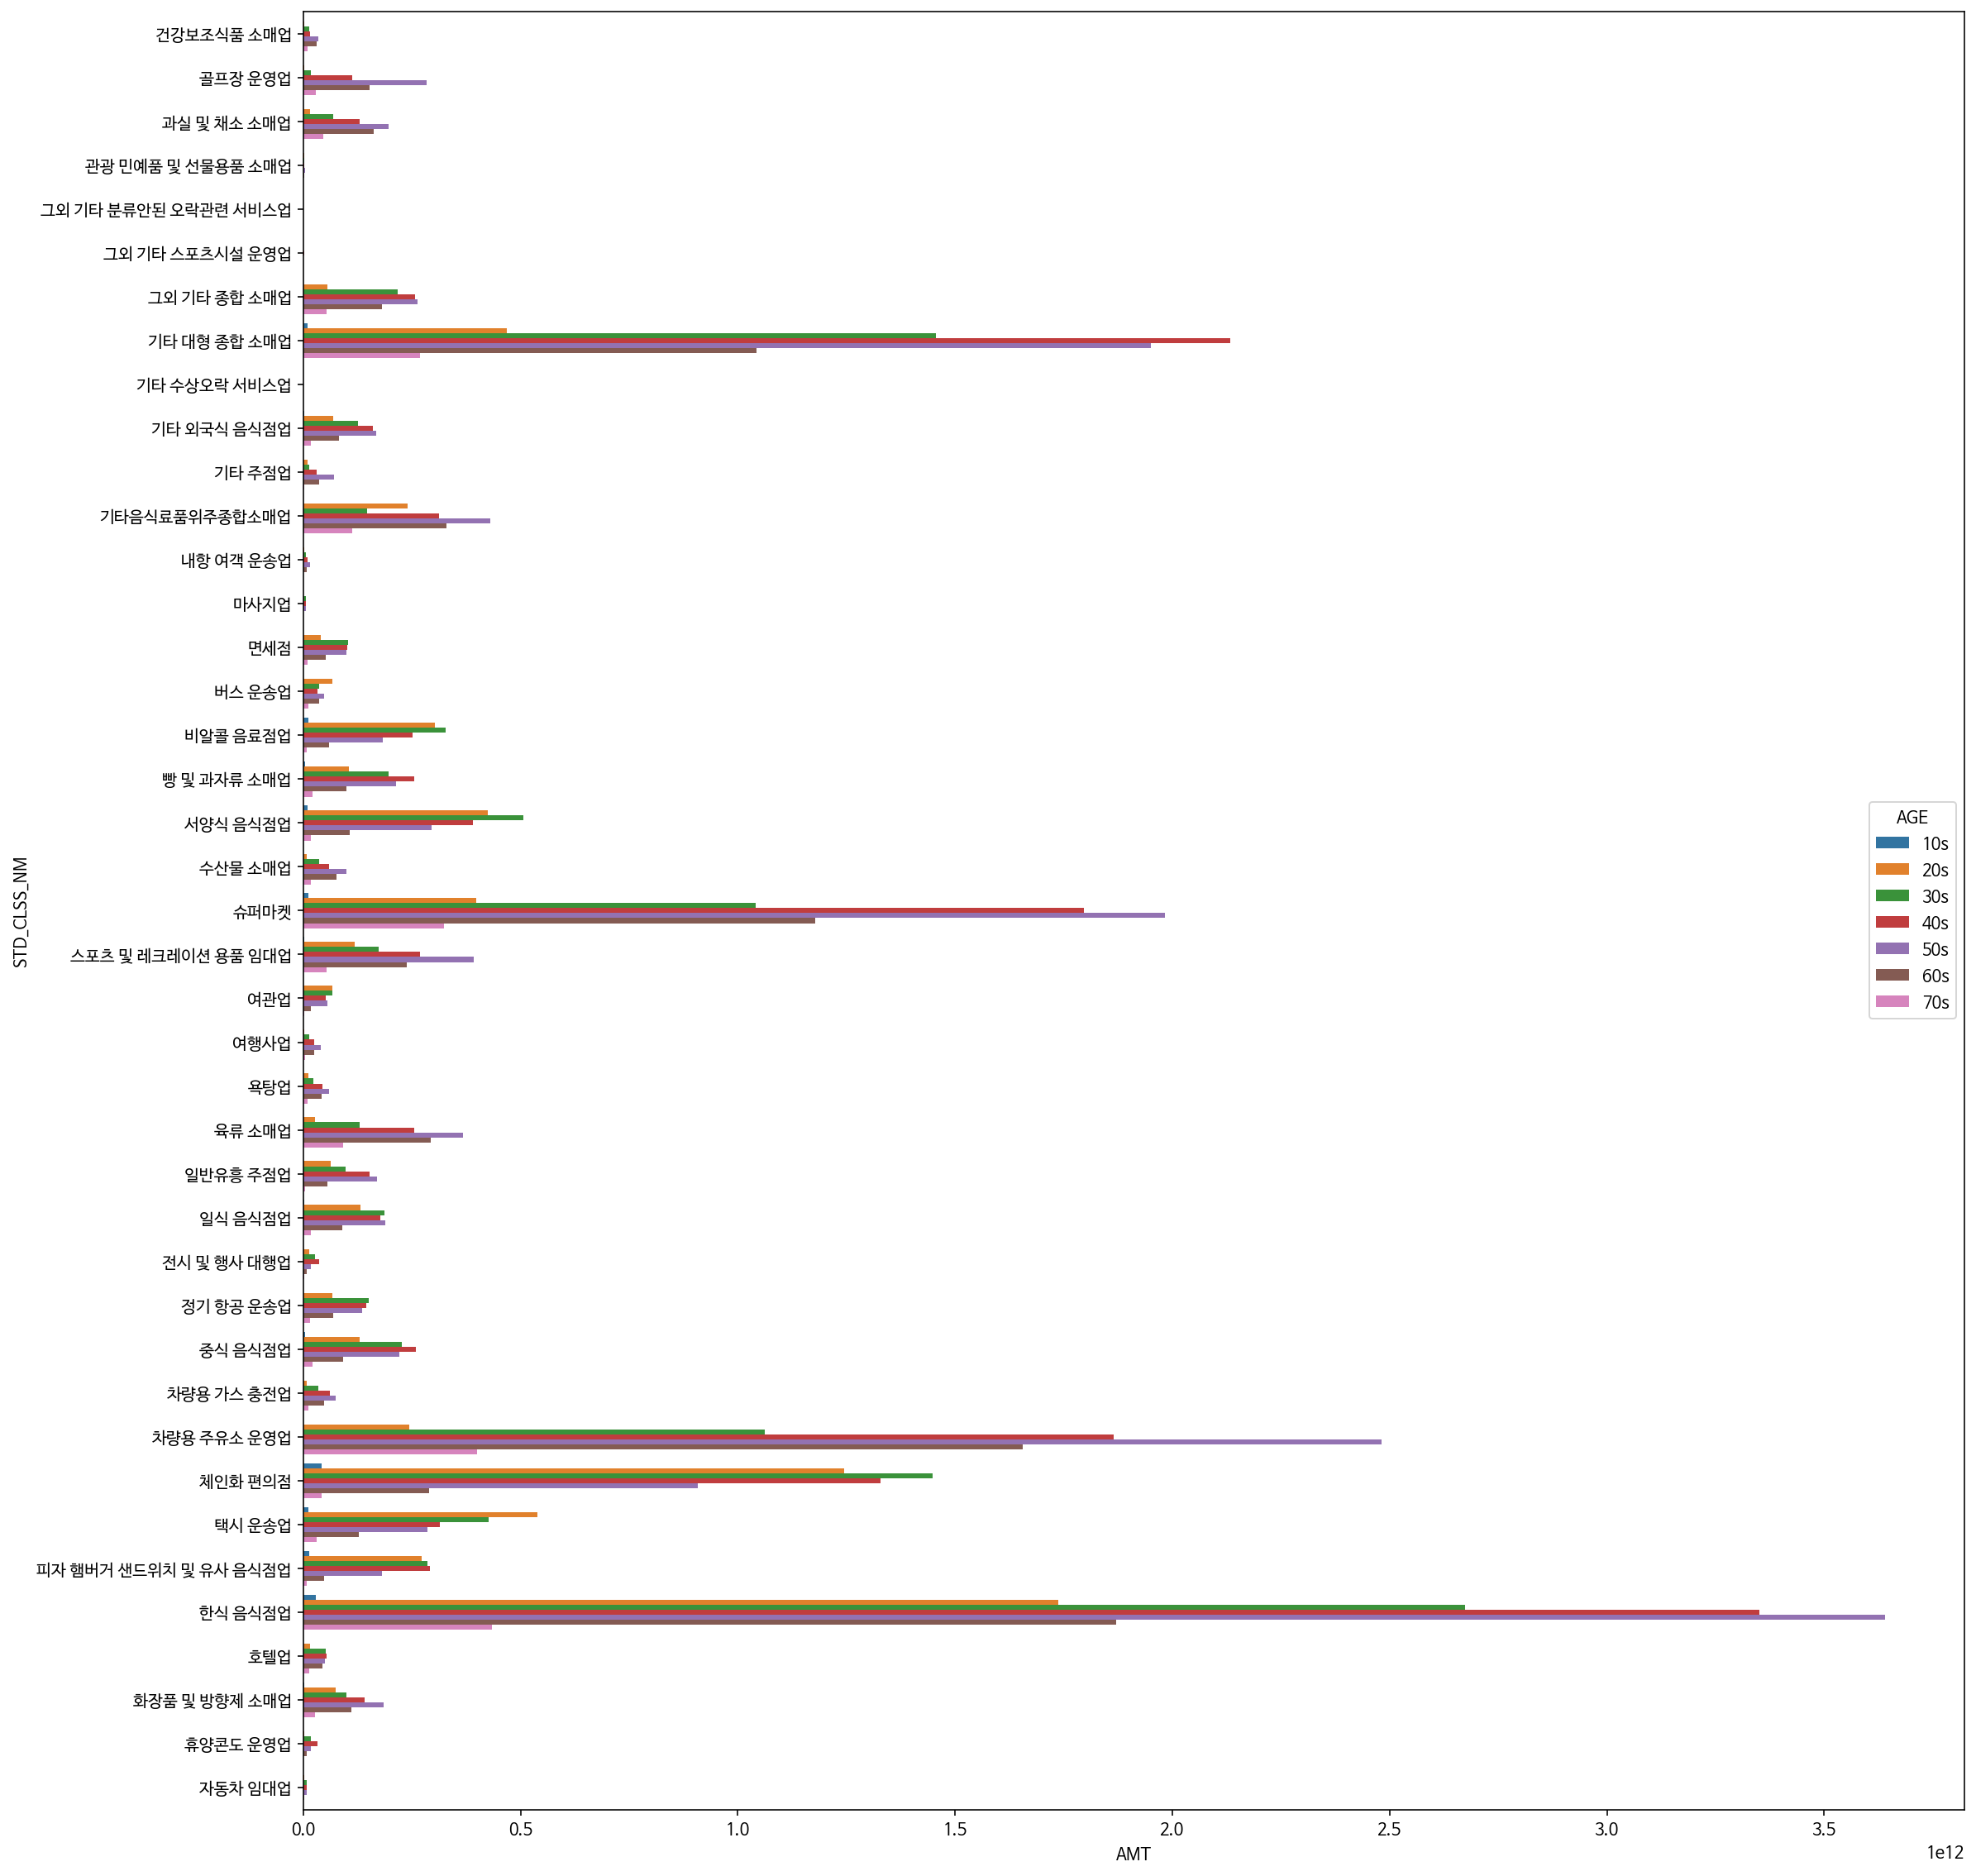

In [ ]:
plt.figure(figsize = (18,20))
sns.barplot(data = age_std, x = 'AMT', y = 'STD_CLSS_NM', orient = 'h', hue='AGE',estimator = np.sum)

In [ ]:
age_std = pd.DataFrame(df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])['AMT'].sum())
age_std = age_std.reset_index()
age_std.head()

,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,강원,건강보조식품 소매업,1820824382
1,강원,골프장 운영업,51290887138
2,강원,과실 및 채소 소매업,16675489268
3,강원,관광 민예품 및 선물용품 소매업,457212008
4,강원,그외 기타 분류안된 오락관련 서비스업,177000


In [ ]:
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT,MY_HOME
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,4,311200,4,1
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,3,605000,3,1
2,강원,건강보조식품 소매업,강원,20s,1,1,2019,6,3,139000,3,1
3,강원,건강보조식품 소매업,강원,20s,1,1,2019,8,3,27500,3,1
4,강원,건강보조식품 소매업,강원,20s,1,1,2019,9,3,395500,3,1


In [ ]:
ganwon = df[df['CARD_SIDO_NM'] == '강원'].copy()
ganwon.drop(['CARD_SIDO_NM'], axis = 1, inplace=True)
ganwon.head()

,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT,MY_HOME
0,건강보조식품 소매업,강원,20s,1,1,2019,1,4,311200,4,1
1,건강보조식품 소매업,강원,20s,1,1,2019,2,3,605000,3,1
2,건강보조식품 소매업,강원,20s,1,1,2019,6,3,139000,3,1
3,건강보조식품 소매업,강원,20s,1,1,2019,8,3,27500,3,1
4,건강보조식품 소매업,강원,20s,1,1,2019,9,3,395500,3,1


In [ ]:
ganwon['REG_YYMM'] = ganwon['year']*100 + ganwon['month']
ganwon_group1 = ganwon.groupby(['REG_YYMM', 'STD_CLSS_NM', 'AGE'])['AMT'].sum()
ganwon_group1 = pd.DataFrame(ganwon_group1).reset_index()
ganwon_group1

,REG_YYMM,STD_CLSS_NM,AGE,AMT
0,201901,건강보조식품 소매업,20s,311200
1,201901,건강보조식품 소매업,30s,13787845
2,201901,건강보조식품 소매업,40s,19838720
3,201901,건강보조식품 소매업,50s,67022381
4,201901,건강보조식품 소매업,60s,36262530
...,...,...,...,...
3528,202003,휴양콘도 운영업,30s,91496229
3529,202003,휴양콘도 운영업,40s,192492991
3530,202003,휴양콘도 운영업,50s,205721036
3531,202003,휴양콘도 운영업,60s,46080352


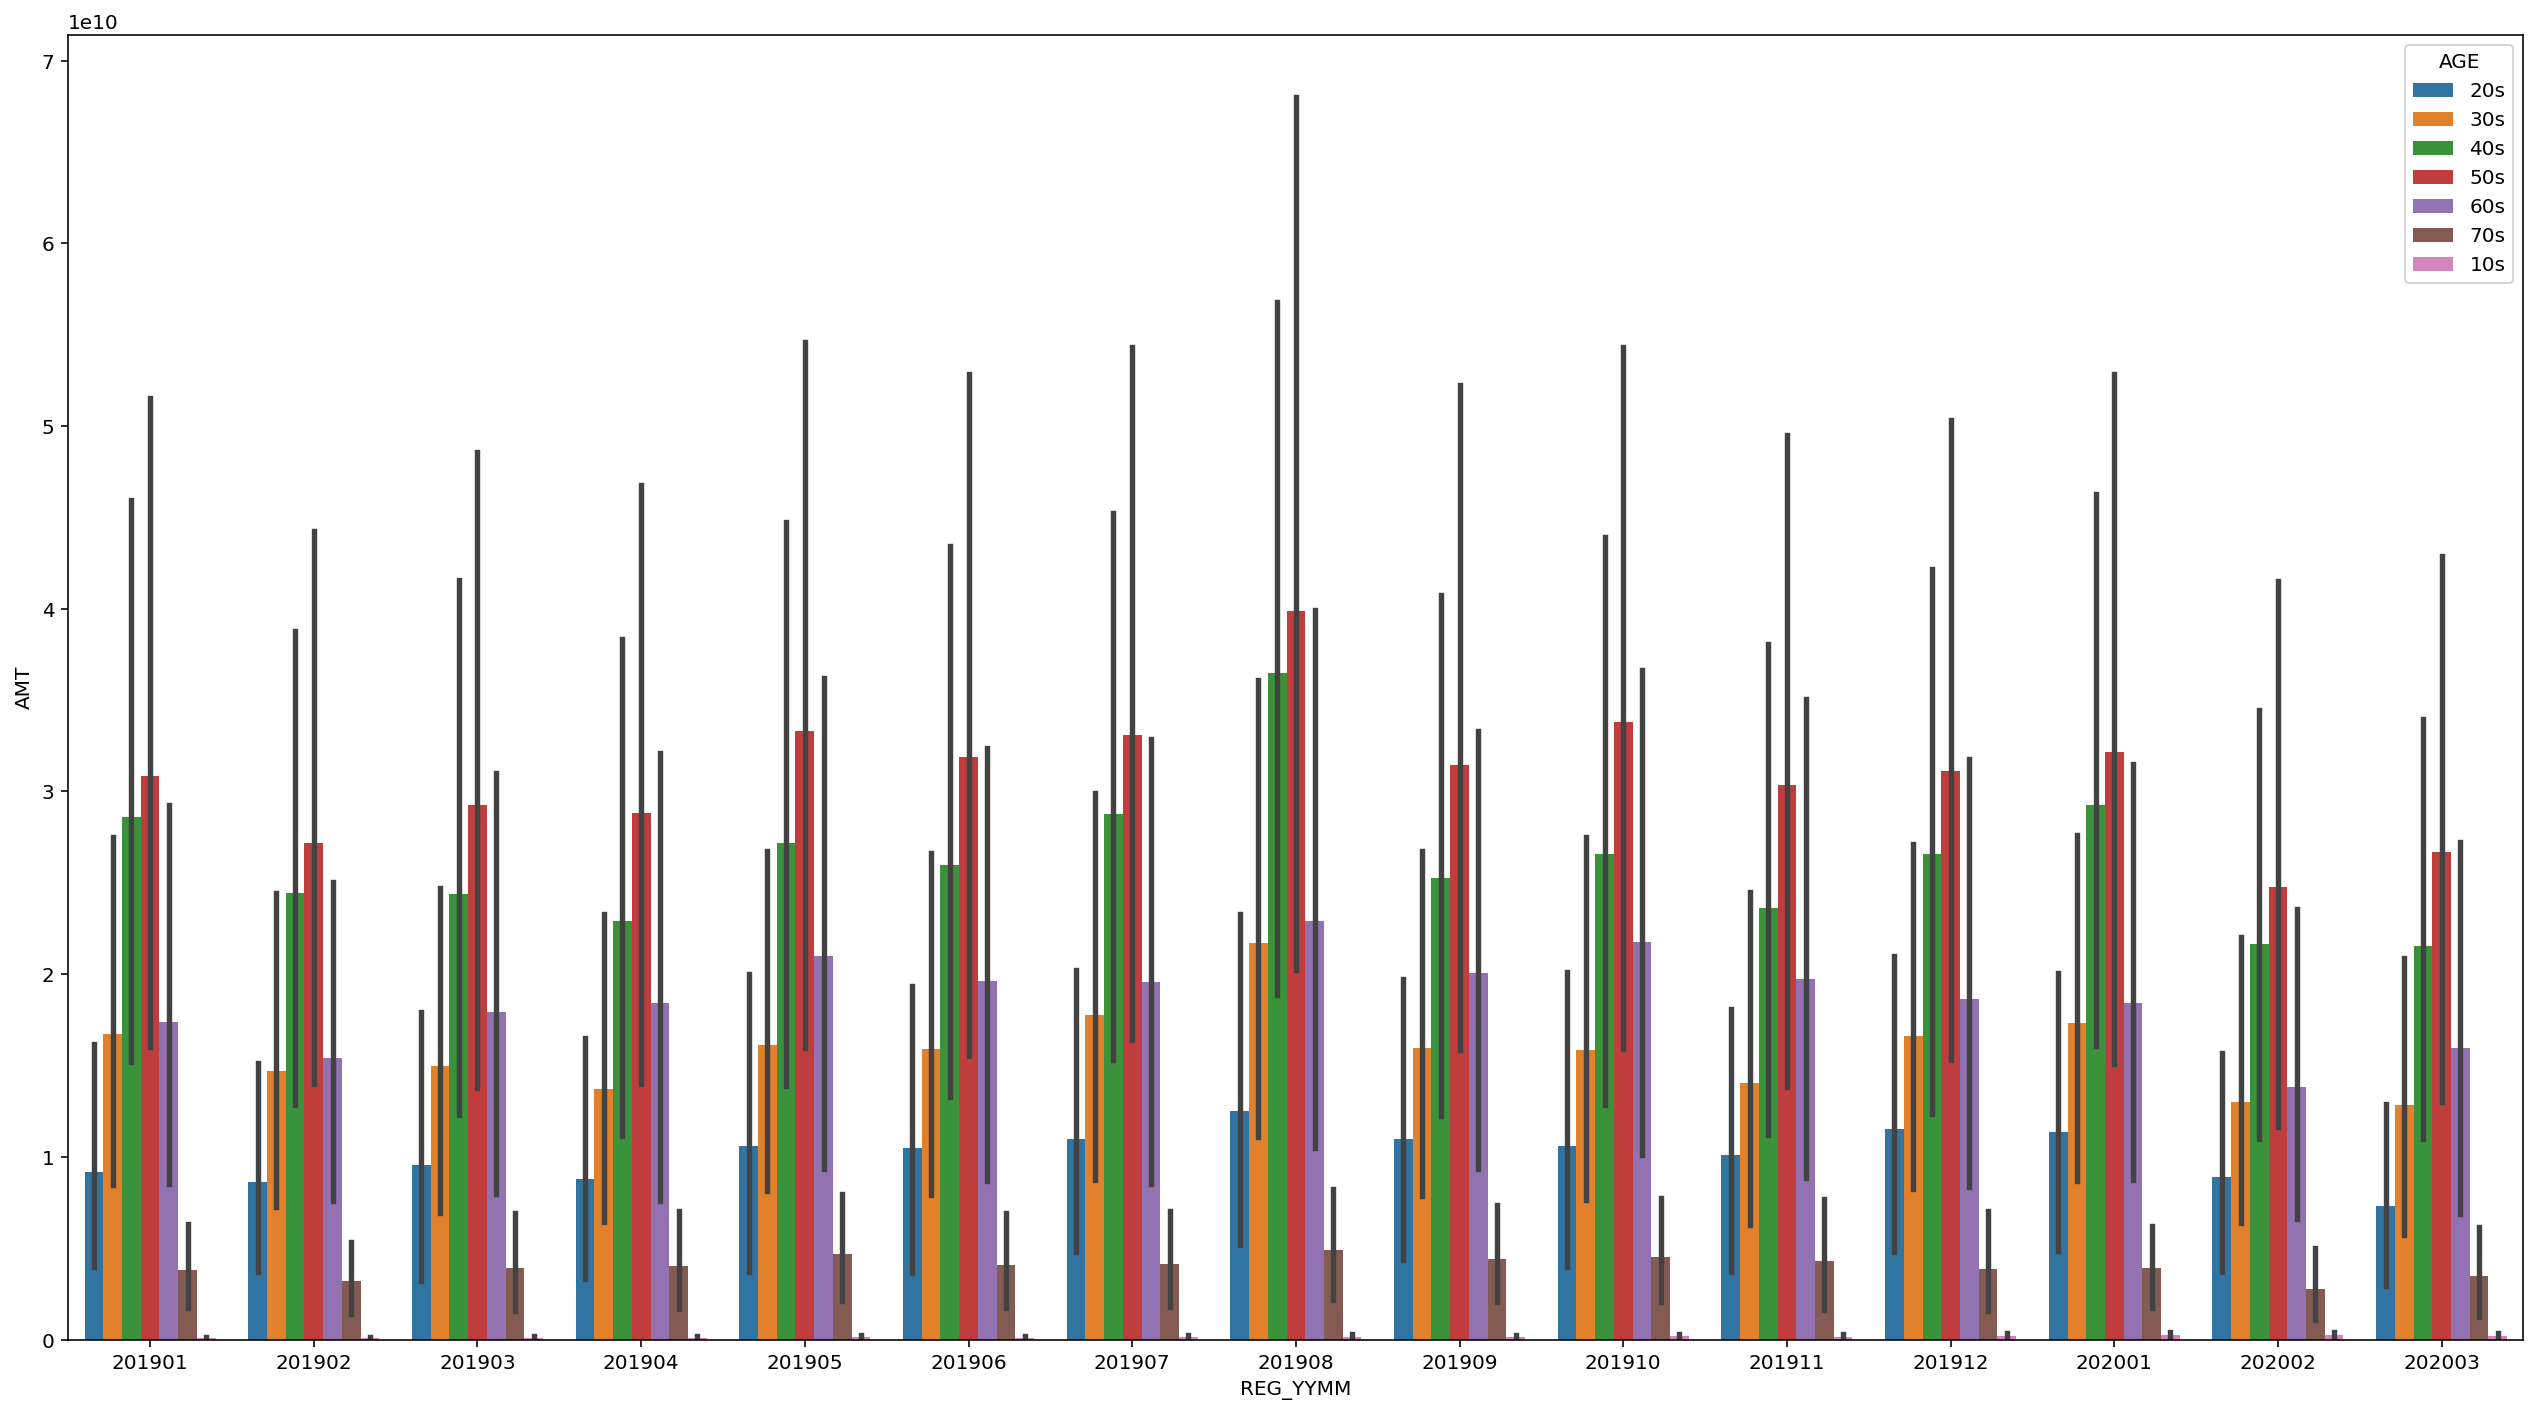

In [ ]:
plt.figure(figsize=(22,12))
sns.barplot(data = ganwon_group1, x = 'REG_YYMM', y = 'AMT', hue = 'AGE', estimator = np.sum)

### Feature Enginnering & Initial Modeling

In [76]:
train_num = df_num.sample(frac = 1, random_state = 0)
train_features = train_num.drop(['AMT'], axis = 1)
train_target = np.log1p(train_num['AMT'])

### Hyperparamter Tuning & Cross Validation

In [ ]:
n_estimators = 10 # 트리의 갯수는 나중에 천천히 올려보겠습니다.
num_epoch = 20    # 반복횟수는 일단 20번 
coarse_hyperparameters_list = [] # hyperparameter 탐색 결과를 리스트로 저장

# num_epoch 횟수만큼 랜덤 서치를 반복합니다.
for epoch in range(num_epoch):
    max_depth = np.random.randint(low = 50, high = 100)
    max_features = np.random.uniform(low = 0.5, high = 1.0)
    model = RandomForestRegressor(n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  n_jobs = -1,
                                  random_state = 4)

    predict = cross_val_predict(model, train_features, train_target, cv = 20)
    y_predict = np.expm1(predict)

    score = mean_squared_log_error(train_num['AMT'], y_predict)
    score = np.sqrt(score)
    
    # hyperparameter 탐색 결과
    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    }
    coarse_hyperparameters_list.append(hyperparameters)
    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, Score = {score:.5f}")

# coarse_hyperparameters_list를 Pandas의 DataFrame으로 변환합니다.
coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)
coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

print(coarse_hyperparameters_list.shape)
coarse_hyperparameters_list.head(10)

 0 n_estimators = 10, max_depth = 96, max_features = 0.952405, Score = 0.75883
 1 n_estimators = 10, max_depth = 57, max_features = 0.815105, Score = 0.77495
 2 n_estimators = 10, max_depth = 95, max_features = 0.637907, Score = 0.81378
 3 n_estimators = 10, max_depth = 70, max_features = 0.810952, Score = 0.77495
 4 n_estimators = 10, max_depth = 76, max_features = 0.643323, Score = 0.81378
 5 n_estimators = 10, max_depth = 74, max_features = 0.706007, Score = 0.81378
 6 n_estimators = 10, max_depth = 72, max_features = 0.954307, Score = 0.75883
 7 n_estimators = 10, max_depth = 66, max_features = 0.950697, Score = 0.75883
 8 n_estimators = 10, max_depth = 65, max_features = 0.797324, Score = 0.77495
 9 n_estimators = 10, max_depth = 99, max_features = 0.870206, Score = 0.77495
10 n_estimators = 10, max_depth = 80, max_features = 0.640559, Score = 0.81378
11 n_estimators = 10, max_depth = 93, max_features = 0.673925, Score = 0.81378
12 n_estimators = 10, max_depth = 89, max_features =

,epoch,score,n_estimators,max_depth,max_features
0,0,0.758831,10,96,0.952405
7,7,0.758831,10,66,0.950697
6,6,0.758831,10,72,0.954307
19,19,0.758831,10,76,0.983919
8,8,0.774948,10,65,0.797324
16,16,0.774948,10,90,0.858006
1,1,0.774948,10,57,0.815105
18,18,0.774948,10,82,0.799245
12,12,0.774948,10,89,0.759333
15,15,0.774948,10,50,0.798504


### Model Tuning & Evaluation

In [77]:
model = RandomForestRegressor(n_estimators = 200,
                              max_depth = 96,
                              max_features = 0.952405,
                              n_jobs = -1, 
                              random_state = 4)
model.fit(train_features, train_target)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=96, max_features=0.952405, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=4, verbose=0, warm_start=False)

In [ ]:
model = GradientBoostingRegressor(random_state = 4,)
model.fit(train_features, train_target)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=4, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
predict = cross_val_predict(model, train_features, train_target, cv = 10)
y_predict = np.expm1(predict)

score = mean_squared_log_error(train_num['AMT'], y_predict)
score = np.sqrt(score)

score

1.8774310136671049

### Conclusion & Discussion

In [34]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                              temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=train_features.columns[:8])
temp.loc[temp['CARD_SIDO_NM'] == temp['HOM_SIDO_NM'], 'MY_HOME'] = 1
temp.loc[temp['CARD_SIDO_NM'] != temp['HOM_SIDO_NM'], 'MY_HOME'] = 0
temp['MY_HOME'] = temp['MY_HOME'].astype(int)

print(temp.shape)
temp.head()

(829430, 9)


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,MY_HOME
0,0,0,0,1,1,1,2020,4,1
1,0,0,0,1,1,2,2020,4,1
2,0,0,0,1,1,3,2020,4,1
3,0,0,0,1,1,4,2020,4,1
4,0,0,0,1,1,5,2020,4,1


In [78]:
# sub과 동일한 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
years         = [2020]
months        = [4]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for year in years:
          for month in months:
            temp.append([CARD_SIDO_NM, STD_CLSS_NM, year, month])

temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=train_features.columns)
print(temp.shape)
temp.head()

(697, 4)


,CARD_SIDO_NM,STD_CLSS_NM,year,month
0,0,0,2020,4
1,0,1,2020,4
2,0,2,2020,4
3,0,3,2020,4
4,0,5,2020,4


In [79]:
# 예측
predict = model.predict(temp)
predict = np.expm1(predict)
temp['AMT'] = np.round(predict, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
pred_AMT = list(temp['AMT'])
temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,0,0,1.299489e+08
1,202004,0,1,2.477090e+09
2,202004,0,2,1.060996e+09
3,202004,0,3,2.050587e+07
4,202004,0,4,1.000120e+06
...,...,...,...,...
692,202004,16,36,1.096698e+09
693,202004,16,37,1.559324e+10
694,202004,16,38,2.019048e+07
695,202004,16,39,4.481673e+08


In [80]:
# RMSLE 계산함수
def rmsle(y, y_,convertExp=False):
    if convertExp:
        y = np.exp(y), 
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

# 2020년 3월과 2020년4월의 AMT값이 거의 같다는 가정으로 2020년3월의 AMT 과 비교하여 단순 모델의 성능향상을 확인해 볼수 있음
data202003 = row_data.copy()
data202003 = data202003[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
data202003 = data202003.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
data202003 = data202003.loc[data202003['REG_YYMM']==202003]
data202003 = data202003[['CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]


submission_temp = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/submission.csv', index_col=0)
submission_temp = submission_temp.loc[submission_temp['REG_YYMM']==202004]
submission_temp = submission_temp[['CARD_SIDO_NM', 'STD_CLSS_NM']]
submission_temp = submission_temp.merge(data202003, left_on=['CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission_temp = submission_temp.fillna(1)
AMT = list(submission_temp['AMT'])

print(rmsle(AMT, pred_AMT))

5.550474106453045


In [81]:
# 디코딩
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [82]:
# 제출 파일 만들기
submission = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.fillna(1)
submission.to_csv('/gdrive/My Drive/data_analysis/jeju/submission_11.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1.299489e+08
1,202004,강원,골프장 운영업,2.477090e+09
2,202004,강원,과실 및 채소 소매업,1.060996e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,2.050587e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,1.000120e+06
